In [60]:
import string
import pandas as pd
import numpy as np
import requests
import unidecode
import re


def try_download_json(url:str) -> pd.DataFrame:

    try:
        response = requests.get(url)
        data = response.json()
        return pd.DataFrame(data)

    except:
        print(f"Erreur de chargement du lien - {url}")
        quit()


def clean_data(df:pd.DataFrame) -> pd.DataFrame:

    liste_salaires = df['lieu'].apply(lambda x : x[1] if len(x) > 1 else '')

    df['lieu'] = df['lieu'].apply(lambda x : unidecode.unidecode(x[0]))

    df['Nom de la société'] = df['Type de poste'].apply(lambda x : x[2] if len(x) > 2 else '')
    df['Type de contrat'] = df['Type de poste'].apply(lambda x : x[7].split(' - ')[0] if len(x) > 7 else '')
    df.drop(columns='Type de poste', inplace=True)

    df = df.apply(lambda c : c.apply(lambda x : ','.join([s.strip("\n ").lower() for s in (x.split(',') if type(x) != list else x)])))

    liste_dates = df['Date de publication'].apply(lambda x: '0 j' if x.find('heures') != -1 else x.removeprefix('postée il y a ').replace('postée hier', '1 j').strip('iorsu'))

    df['Date de publication'] = pd.to_datetime(liste_dates.apply(
        lambda x :
            pd.to_datetime("2023-01-15") - (pd.DateOffset(months=int(x.split()[0])) if x.split()[1] == 'm' else pd.DateOffset(days=int(x.split()[0])))
        ))

    df['Salaire minimum'] = liste_salaires.apply(lambda x : float(x.split(' - ')[0].strip(' €\n').replace('.', '').replace(',', '.')) if x != '' else np.nan)
    df['Salaire maximum'] = liste_salaires.apply(lambda x : float(x.split(' - ')[1].strip(' €/an\n' + string.ascii_letters).replace('.', '').replace(',', '.')) if x != '' else np.nan)

    noms_ville = ['la defense', 'guyancourt', 'antony', 'paris']

    df['lieu'] = df['lieu'].apply(
        lambda x :
            ([n for n in noms_ville for i in x.replace(' - ', ',').replace('-', ' ').split(',') if n in i] + [x.replace('-', ' ')])[0]
        )

    #remplace si data analyst dans vavlue par data analyste etc
    terms_to_replace = {'analyst': 'data analyst', 'datascientist': 'data scientist', 'data engineer': 'ingénieur','conultant/analyste': 'consultant/analyste','2018788': '',
                        'developer': 'developpeur','full stacke': 'developpeur','global technical seo manager': 'manager','engineer': 'ingenieur','lead': 'chef','full': 'developpeur','ingénieur': 'ingenieur','analyste': 'data analyst','product': 'chef de projet'}
    df["Intitulé du poste"] = df["Intitulé du poste"].apply(lambda x: ' '.join([terms_to_replace.get(term, term) for term in unidecode.unidecode(x).split()]))

    keywords = ["stage","business analyst","analyste fonctionnel","architecte","apprenti","data ingenieur","data ingénieur", "data engineer","data analyst","data scientist","consultant","ingenieur","chef de projet","concepteur","alternance",
                "technical leader","technicien","responsable","référent","expert","developpeur","specialiste","referent","manager","postdoctorant","internship"]

    for keyword in keywords:
        df["Intitulé du poste"] = df["Intitulé du poste"].str.replace(rf"(.*{keyword})", keyword, regex=True)
        df["Intitulé du poste"] = df["Intitulé du poste"].str.replace(rf"({keyword}.*)", keyword, regex=True)

    df['Intitulé du poste'] = df['Intitulé du poste'].apply(lambda x: re.sub(r'[hf]/[hf]|[-\/()]', '', x))

    return df


def main():

    url = "https://raw.githubusercontent.com/Lorenzo1208/Projet_TrouveTonJob/main/data.json"

    df = try_download_json(url)
    df = clean_data(df)

    df.to_csv("data_clean.csv")


if __name__ == '__main__':
    main()

In [69]:
df2["lieu"].isin(["Paris"])

0      False
1      False
2      False
3      False
4      False
       ...  
945    False
946    False
947    False
948    False
949    False
Name: lieu, Length: 950, dtype: bool

In [30]:

def try_read_csv(url2) -> pd.DataFrame:

    try:
        df2 = pd.read_csv(url2)
        return df2

    except:
        print(f"Erreur de lecture du csv - {url2}")
        quit()
        

def clean_data_scrapping(df2:pd.DataFrame) -> pd.DataFrame:

    # # Check if salary is in monthly, if yes, multiply by 12
    # df2['Salaires'] = df2['Salaires'].apply(lambda x: x['Salaires'].replace("Mensuel de ", "").replace(" Euros à "," - ").replace(" Euros sur 12 mois", "") if 'Mensuel' in x['Salaires'] else x['Salaires'], axis=1)

    # # Extract minimum and maximum salary values
    # df2[['salary_min', 'salary_max']] = df2['Salaires'].str.extract('(?P<salary_min>\d+[.,]?\d+)[ -]+(?P<salary_max>\d+[.,]?\d+)', expand=True)

    # # convert columns to numeric
    # df2[['salary_min', 'salary_max']] = df2[['salary_min', 'salary_max']].apply(pd.to_numeric)

    # # multiply by 12 if salary is monthly
    # df2[['salary_min', 'salary_max']] = df2.apply(lambda x: x[['salary_min', 'salary_max']]*12 if 'Mensuel' in x['Salaires'] else x[['salary_min', 'salary_max']], axis=1)

    # # Replace NaN values with None
    # df2.replace(np.nan, '', inplace=True)

    # # Replace non-numeric values with None
    # df2.replace(r'[^\d.,]+', '', regex=True, inplace=True)
    
    df2 = df2.drop(['Unnamed: 0'], axis=1)

    df2 = df2.applymap(lambda x: x.lower() if type(x) == str else x)

     #remplace si data analyst dans vavlue par data analyste etc
    terms_to_replace = {'consultante': 'consultant','analyst': 'data analyst','Data Analyst': 'data analyst', 'datascientist': 'data scientist', 'data engineer': 'ingénieur','conultant/analyste': 'consultant/analyste','2018788': '',
                        'developer': 'developpeur','full stack': 'developpeur','global technical seo manager': 'manager','engineer': 'ingenieur','lead': 'chef','full': 'developpeur','ingénieur': 'ingenieur',
                        'analyste': 'data analyst','product': 'chef de projet'}
    
    df2["Intitulé du poste"] = df2["Intitulé du poste"].apply(lambda x: ' '.join([terms_to_replace.get(term, term) for term in unidecode.unidecode(x).split()]))

    keywords = ["stage","business analyst","analyste fonctionnel","architecte","apprenti","data ingenieur","data ingénieur", "data engineer","data analyst","data scientist","consultant","ingenieur",
                "chef de projet","concepteur","alternance","technical leader","technicien","responsable","référent","expert","developpeur","specialiste","referent","manager","postdoctorant","internship"]

    for keyword in keywords:
        df2["Intitulé du poste"] = df2["Intitulé du poste"].str.replace(rf"(.*{keyword})", keyword, regex=True)
        df2["Intitulé du poste"] = df2["Intitulé du poste"].str.replace(rf"({keyword}.*)", keyword, regex=True)

    df2['Intitulé du poste'] = df2['Intitulé du poste'].apply(lambda x: re.sub(r'[hf]/[hf]|[-\/()]', '', x))
    

    return df2


def main():

    url2 = "https://raw.githubusercontent.com/Lorenzo1208/Projet_TrouveTonJob/main/data_scrapping.csv"

    df2 = try_read_csv(url2)
    df2 = clean_data_scrapping(df2)
    df2.to_csv("data_scrapping_clean.csv")

if __name__ == '__main__':
    main()

In [21]:
df2 = pd.read_csv("data_scrapping_clean.csv")
df2.dtypes

Unnamed: 0.1            int64
Unnamed: 0              int64
Intitulé du poste      object
Date de publication    object
lieu                   object
competences            object
Nom de la société      object
Type de contrat        object
Salaires               object
dtype: object

In [2]:
df = pd.read_csv("data_clean.csv")
df = df.dropna(subset=["competences"])
df = df[df["competences"] != ""]
df["competences"] = df["competences"].str.split(",")
df_exploded = df.explode('competences')
df["competences"]


0                                [sql, t-sql, outils]
1          [support, outils, agile, design, big data]
2               [crm, data quality, sql, sas, python]
3                                  [si, support, sap]
4           [outils, support, decisionnel, sql, test]
                            ...                      
225          [sap, abap, progiciel, système, support]
226      [digital, outils, securité, sécurité, t-sql]
227              [test, serveur, jquery, mobile, tdd]
228      [nosql, unix, java, machine learning, linux]
229    [big data, support, python, réseaux, securité]
Name: competences, Length: 229, dtype: object

In [3]:
competences_count = df_exploded["competences"].value_counts()
top_5_competences = competences_count.nlargest(5)
top_5_competences = top_5_competences.index
print(top_5_competences)

Index(['outils', 'support', 'si', 'big data', 'securité'], dtype='object')


In [4]:
unique_types = df["Type de contrat"].unique()
unique_types = unique_types[~pd.isna(unique_types)]
print(unique_types)

['cdi' 'cdd/intérim' 'stage' 'contrat de professionnalisation'
 "contrat d'apprentissage"]


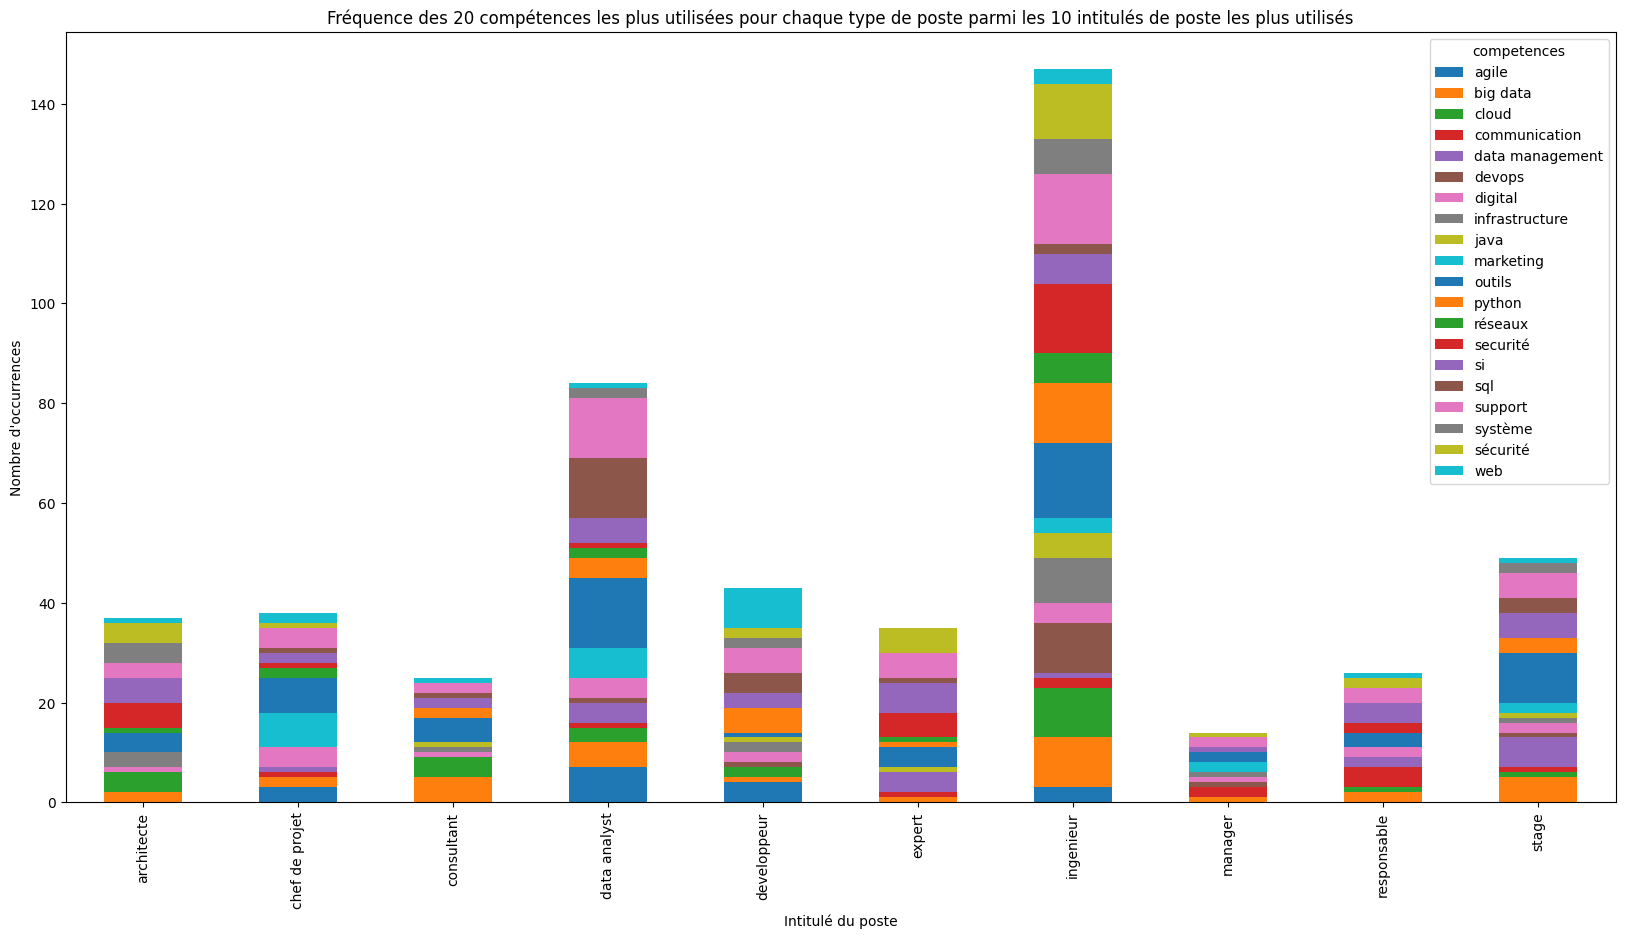

In [34]:
import matplotlib.pyplot as plt

df = pd.read_csv("data_clean.csv")
df = df.dropna(subset=["competences"])
df = df[df["competences"] != ""]
df["competences"] = df["competences"].str.split(",")
df_exploded = df.explode('competences')
competences_count = df_exploded["competences"].value_counts()
top_20_competences = competences_count.nlargest(20)
top_20_competences = top_20_competences.index
job_title_count = df['Intitulé du poste'].value_counts()
top_10_job_titles = job_title_count.nlargest(10)
top_10_job_titles = top_10_job_titles.index
df_filtered = df_exploded[df_exploded["Intitulé du poste"].isin(top_10_job_titles)]
df_filtered = df_filtered[df_filtered["competences"].isin(top_20_competences)]
competences_count = df_filtered.groupby(["Intitulé du poste", "competences"]).size().reset_index(name="count")
competences_count = competences_count.pivot(index='Intitulé du poste', columns='competences', values='count')
competences_count.plot(kind="bar", stacked=True, figsize=(20, 10))
plt.xlabel("Intitulé du poste")
plt.ylabel("Nombre d'occurrences")
plt.title("Fréquence des 20 compétences les plus utilisées pour chaque type de poste parmi les 10 intitulés de poste les plus utilisés")
plt.show()
#dans l'ordre

In [35]:
import matplotlib.pyplot as plt

df = pd.read_csv("data_clean.csv")
df = df.dropna(subset=["competences"])
df = df[df["competences"] != ""]
df["competences"] = df["competences"].str.split(",")
df_exploded = df.explode('competences')
competences_count = df_exploded["competences"].value_counts()
top_20_competences = competences_count.nlargest(20)
job_title_count = df['Intitulé du poste'].value_counts()
top_10_job_titles = job_title_count.nlargest(10)
df_filtered = df_exploded[df_exploded["Intitulé du poste"].isin(top_10_job_titles)]
df_filtered = df_filtered[df_filtered["competences"].isin(top_20_competences)]
competences_count = df_filtered.groupby(["Intitulé du poste", "competences"]).size().reset_index(name="count")
competences_count = competences_count.pivot(index='Intitulé du poste', columns='competences', values='count')
competences_count = competences_count[top_20_competences[::-1]]
competences_count.plot(kind="bar", stacked=True, figsize=(20, 10))
plt.xlabel("Intitulé du poste")
plt.ylabel("Nombre d'occurrences")
plt.title("Fréquence des 20 compétences les plus utilisées pour chaque type de poste parmi les 10 intitulés de poste les plus utilisés")
plt.show()

KeyError: "None of [Int64Index([14, 17, 17, 18, 18, 20, 23, 24, 24, 26, 27, 30, 30, 30, 33, 35, 45,\n            46, 70, 80],\n           dtype='int64', name='competences')] are in the [columns]"

In [55]:
# data
import pandas as pd

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler

# Pipeline and model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

# Score of models
from sklearn.metrics import accuracy_score

In [56]:
df = pd.read_csv("data_clean.csv")
df.columns

Index(['Unnamed: 0', 'Intitulé du poste', 'Date de publication', 'lieu',
       'competences', 'Nom de la société', 'Type de contrat',
       'Salaire minimum', 'Salaire maximum'],
      dtype='object')

In [57]:
y = df['Salaire minimum'].dropna()

In [58]:
# features preprocessing
X = df.drop(columns='Salaire minimum')
X.head()

,Unnamed: 0,Intitulé du poste,Date de publication,lieu,competences,Nom de la société,Type de contrat,Salaire maximum
0,0,data analyst,2022-12-25,paris,"sql,t-sql,outils",sept lieues sas,cdi,NaN
1,1,data analyst,2022-12-15,la defense,"support,outils,agile,design,big data",edf france,cdi,NaN
2,2,data analyst,2022-12-19,paris,"crm,data quality,sql,sas,python",hermès,cdi,NaN
3,3,data analyst,2022-12-25,moussy le vieux,"si,support,sap",tereos,cdi,NaN
4,4,data analyst,2023-01-12,france,"outils,support,decisionnel,sql,test",safran-group,cdi,NaN


In [16]:
df.dtypes

Unnamed: 0               int64
Intitulé du poste       object
Date de publication     object
lieu                    object
competences             object
Nom de la société       object
Type de contrat         object
Salaire minimum        float64
Salaire maximum        float64
dtype: object

In [76]:
# selection of categorical variables
column_cat = X.select_dtypes(include=['object']).columns
column_cat

Index(['Intitulé du poste', 'Date de publication', 'lieu', 'competences',
       'Nom de la société', 'Type de contrat'],
      dtype='object')

In [77]:
transfo_cat = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse = False))
])

In [78]:
# selection of numerical variables
column_num = X.select_dtypes(exclude=['object']).columns.drop(['Unnamed: 0'])
column_num

Index(['Salaire maximum'], dtype='object')

In [79]:
# Numerical variables
transfo_num = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='median')),
    ('scaling', MinMaxScaler())
])

In [81]:
# Class ColumnTransformer : apply alls steps on the whole dataset
preparation = ColumnTransformer(
    transformers=[
        ('data_cat', transfo_cat , column_cat),
        ('data_num', transfo_num , column_num),
        #('data_artist', transfo_text , 'artist_name'),
    ])

In [65]:
# Creation of model : a ready to use pipeline for ML process
#model = LogisticRegression(penalty='elasticnet', l1_ratio=0.2, multi_class='ovr', solver='saga') #GaussianNB() #GradientBoostingClassifier() #CategoricalNB() #SVC() #CategoricalNB()#
model = LogisticRegression(penalty='l1', max_iter=5000, solver='saga')

# A tester pour meilleur temps d'entrainement : 
# - LogisticRegressionCV(penalty='l1', max_iter=5000, solver='saga')
# - SGDClassifier()

pipe_model = Pipeline(steps=[('preparation', preparation),
                        ('model',model)])
pipe_model

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_cat',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['Intitulé du poste', 'Date de publication', 'lieu', 'Nom de la société',
       'Type de contrat'],
      dtype='object')),
                                                 ('data_num',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   MinMaxScaler())]),
                                                  Index(['Salaire maximum'], dtype='object')),
                                                 ('data_mot',
                                                  Pipeline(steps=[('bow',
                                                                   CountVectorizer())]),
                                                  'competences')])),
                ('model',
                 LogisticRegression(max_iter=5000, penalty='l1',
                                    solver='saga'))])

In [66]:
from sklearn import set_config
set_config(display='diagram')
pipe_model

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_cat',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['Intitulé du poste', 'Date de publication', 'lieu', 'Nom de la société',
       'Type de contrat'],
      dtype='object')),
                                                 ('data_num',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   MinMaxScaler())]),
                                                  Index(['Salaire maximum'], dtype='object')),
                                                 ('data_mot',
                                                  Pipeline(steps=[('bow',
                                                                   CountVectorizer())]),
                                                  'competences')])),
                ('model',
                 LogisticRegression(max_iter=5000, penalty='l1',
                                    solver='saga'))])

In [67]:
print(X.shape)
print(y.shape)

(230, 8)
(43,)


In [70]:
X.dropna(inplace=True)
y.dropna(inplace=True)
print(X.shape)
print(y.shape)

(39, 8)
(43,)


In [72]:
from sklearn.utils import resample

# Get the number of samples in y
n_samples = len(X)

# Resample X and y to have the same number of samples
X_resampled, y_resampled = resample(X, y, n_samples=n_samples, random_state=2)


ValueError: Found input variables with inconsistent numbers of samples: [39, 43]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=2, stratify=y_resampled)

NameError: name 'X_resampled' is not defined